In [1]:
import torch
import numpy as np
import jieba
import pandas as pd

data_dir = 'https://mirror.coggle.club/dataset/coggle-competition/'
train_data = pd.read_csv(data_dir + 'intent-classify/train.csv', sep='\t', header=None)
test_data = pd.read_csv(data_dir + 'intent-classify/test.csv', sep='\t', header=None)

# train_data = train_data.sample(frac=1.0)
train_data[1], lbl = pd.factorize(train_data[1])

In [2]:
len(lbl)

12

In [3]:
train_data.head()

,0,1
0,还有双鸭山到淮阴的汽车票吗13号的,0
1,从这里怎么回家,0
2,随便播放一首专辑阁楼里的佛里的歌,1
3,给看一下墓王之王嘛,2
4,我想看挑战两把s686打突变团竞的游戏视频,3


In [4]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import random
import re

In [5]:
# 划分为训练集和验证集
# stratify 按照标签进行采样，训练集和验证部分同分布
x_train, x_test, train_label, test_label = train_test_split(train_data[0].values,
                                                            train_data[1].values,
                                                            test_size=0.2,
                                                            stratify=train_data[1].values)

<Axes: ylabel='Frequency'>

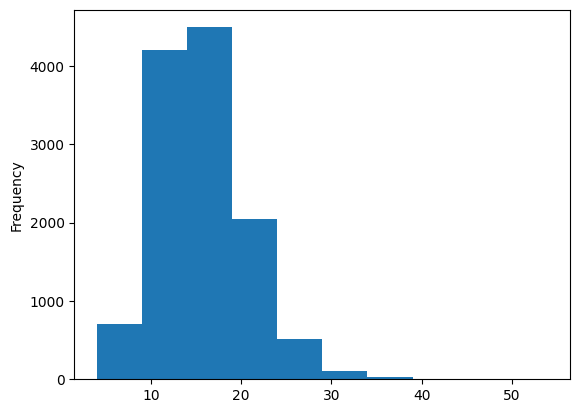

In [6]:
train_data[0].apply(len).plot(kind='hist')

In [7]:
# input_ids：字的编码
# token_type_ids：标识是第一个句子还是第二个句子
# attention_mask：标识是不是填充

In [8]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

from transformers import AutoTokenizer, AutoModelForMaskedLM
tokenizer = AutoTokenizer.from_pretrained("/home/lyz/hf-models/hfl/chinese-macbert-large")

train_encoding = tokenizer(list(x_train), truncation=True, padding=True, max_length=30)
test_encoding = tokenizer(list(x_test), truncation=True, padding=True, max_length=30)

In [9]:
import torch
from peft import LoraConfig, TaskType
from peft import get_peft_model
from transformers import BertForSequenceClassification

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=50, lora_alpha=1, lora_dropout=0.01
)
model = BertForSequenceClassification.from_pretrained(
    '/home/lyz/hf-models/hfl/chinese-macbert-large/', num_labels=12
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-large/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 4,927,500 || all params: 330,462,232 || trainable%: 1.491093239362978


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(21128, 1024, padding_idx=0)
          (position_embeddings): Embedding(512, 1024)
          (token_type_embeddings): Embedding(2, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-23): 24 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.01, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (defa

In [10]:
# 数据集读取
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    # 读取单个样本
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = NewsDataset(train_encoding, train_label)
test_dataset = NewsDataset(test_encoding, test_label)

In [11]:
train_dataset[1]

{'input_ids': tensor([ 101, 3221,  679, 3221, 5543, 2828, 6825, 5330, 1196, 5326, 5330, 3064,
          671,  678, 1450,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]),
 'labels': tensor(2)}

In [12]:
# 精度计算
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练函数
def train(model, train_loader, epoch):
    model.train()
    total_train_loss = 0
    iter_num = 0
    total_iter = len(train_loader)
    for batch in train_loader:
        # 正向传播
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_train_loss += loss.item()

        # 反向梯度信息
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 参数更新
        optim.step()
        # scheduler.step()

        iter_num += 1
        if(iter_num % 100 == 0):
            print("epoth: %d, iter_num: %d, loss: %.4f, %.2f%%" % (epoch, iter_num, loss.item(), iter_num/total_iter*100))

    print("Epoch: %d, Average training loss: %.4f" % (epoch, total_train_loss/len(train_loader)))


def validation(model, val_dataloader):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in val_dataloader:
        with torch.no_grad():
            # 正常传播
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        logits = outputs[1]

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("Accuracy: %.4f" % (avg_val_accuracy))
    print("Average testing loss: %.4f" % (total_eval_loss/len(val_dataloader)))
    print("-------------------------------")

In [15]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fold = 0
for train_idx, val_idx in kf.split(train_data[0].values, train_data[1].values,):
    print(train_idx)
    train_text = train_data[0].iloc[train_idx]
    val_text = train_data[0].iloc[train_idx]

    train_label = train_data[1].iloc[train_idx].values
    val_label = train_data[1].iloc[train_idx].values

    train_encoding = tokenizer(list(train_text), truncation=True, padding=True, max_length=30)
    val_encoding = tokenizer(list(val_text), truncation=True, padding=True, max_length=30)

    # 默认是没有数据扩增，文本默认是没有变换的操作
    train_dataset = NewsDataset(train_encoding, train_label)
    val_dataset = NewsDataset(val_encoding, val_label)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)


    # peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.01)
    model = BertForSequenceClassification.from_pretrained(
        '/home/lyz/hf-models/hfl/chinese-macbert-large/', num_labels=12
    )
    # model = get_peft_model(model, lora_config)
    model.to(device)
    
    # 优化方法
    optim = AdamW(model.parameters(), lr=1e-5)
    total_steps = len(train_loader) * 1
    scheduler = get_linear_schedule_with_warmup(optim,
                                                num_warmup_steps=0,  # Default value in run_glue.py
                                                num_training_steps=total_steps)

    for epoch in range(5):
        train(model, train_loader, epoch)
        validation(model, val_dataloader)

    torch.save(model.state_dict(), 'model_' + str(fold) + '.pt')

    fold += 1

[ 2420  2421  2422 ... 12097 12098 12099]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-large/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/lyz/anaconda3/envs/py311/lib/python3.11/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoth: 0, iter_num: 100, loss: 0.5732, 16.53%
epoth: 0, iter_num: 200, loss: 0.0713, 33.06%
epoth: 0, iter_num: 300, loss: 0.9274, 49.59%
epoth: 0, iter_num: 400, loss: 0.0207, 66.12%
epoth: 0, iter_num: 500, loss: 0.3288, 82.64%
epoth: 0, iter_num: 600, loss: 0.0508, 99.17%
Epoch: 0, Average training loss: 0.4703
Accuracy: 0.9567
Average testing loss: 0.1515
-------------------------------
epoth: 1, iter_num: 100, loss: 0.3391, 16.53%
epoth: 1, iter_num: 200, loss: 0.0278, 33.06%
epoth: 1, iter_num: 300, loss: 0.0591, 49.59%
epoth: 1, iter_num: 400, loss: 0.3624, 66.12%
epoth: 1, iter_num: 500, loss: 0.3643, 82.64%
epoth: 1, iter_num: 600, loss: 0.6247, 99.17%
Epoch: 1, Average training loss: 0.1747
Accuracy: 0.9771
Average testing loss: 0.0831
-------------------------------
epoth: 2, iter_num: 100, loss: 0.0594, 16.53%
epoth: 2, iter_num: 200, loss: 0.0027, 33.06%
epoth: 2, iter_num: 300, loss: 0.2754, 49.59%
epoth: 2, iter_num: 400, loss: 0.0014, 66.12%
epoth: 2, iter_num: 500, los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-large/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoth: 0, iter_num: 100, loss: 0.7529, 16.53%
epoth: 0, iter_num: 200, loss: 0.3124, 33.06%
epoth: 0, iter_num: 300, loss: 0.0973, 49.59%
epoth: 0, iter_num: 400, loss: 0.1018, 66.12%
epoth: 0, iter_num: 500, loss: 0.0297, 82.64%
epoth: 0, iter_num: 600, loss: 0.2207, 99.17%
Epoch: 0, Average training loss: 0.5043
Accuracy: 0.9549
Average testing loss: 0.1536
-------------------------------
epoth: 1, iter_num: 100, loss: 0.0143, 16.53%
epoth: 1, iter_num: 200, loss: 0.1158, 33.06%
epoth: 1, iter_num: 300, loss: 0.2074, 49.59%
epoth: 1, iter_num: 400, loss: 0.9149, 66.12%
epoth: 1, iter_num: 500, loss: 0.2557, 82.64%
epoth: 1, iter_num: 600, loss: 0.0915, 99.17%
Epoch: 1, Average training loss: 0.1685
Accuracy: 0.9783
Average testing loss: 0.0822
-------------------------------
epoth: 2, iter_num: 100, loss: 0.0121, 16.53%
epoth: 2, iter_num: 200, loss: 0.0015, 33.06%
epoth: 2, iter_num: 300, loss: 0.0043, 49.59%
epoth: 2, iter_num: 400, loss: 0.0266, 66.12%
epoth: 2, iter_num: 500, los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-large/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoth: 0, iter_num: 100, loss: 0.3347, 16.53%
epoth: 0, iter_num: 200, loss: 0.4755, 33.06%
epoth: 0, iter_num: 300, loss: 0.3466, 49.59%
epoth: 0, iter_num: 400, loss: 0.5965, 66.12%
epoth: 0, iter_num: 500, loss: 0.6385, 82.64%
epoth: 0, iter_num: 600, loss: 0.3223, 99.17%
Epoch: 0, Average training loss: 0.5012
Accuracy: 0.9476
Average testing loss: 0.1758
-------------------------------
epoth: 1, iter_num: 100, loss: 0.0254, 16.53%
epoth: 1, iter_num: 200, loss: 0.0565, 33.06%
epoth: 1, iter_num: 300, loss: 0.9993, 49.59%
epoth: 1, iter_num: 400, loss: 0.3394, 66.12%
epoth: 1, iter_num: 500, loss: 0.2983, 82.64%
epoth: 1, iter_num: 600, loss: 0.0101, 99.17%
Epoch: 1, Average training loss: 0.1668
Accuracy: 0.9772
Average testing loss: 0.0792
-------------------------------
epoth: 2, iter_num: 100, loss: 0.2335, 16.53%
epoth: 2, iter_num: 200, loss: 0.0140, 33.06%
epoth: 2, iter_num: 300, loss: 0.0057, 49.59%
epoth: 2, iter_num: 400, loss: 0.1011, 66.12%
epoth: 2, iter_num: 500, los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-large/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoth: 0, iter_num: 100, loss: 0.3930, 16.53%
epoth: 0, iter_num: 200, loss: 0.0485, 33.06%
epoth: 0, iter_num: 300, loss: 0.4751, 49.59%
epoth: 0, iter_num: 400, loss: 0.2490, 66.12%
epoth: 0, iter_num: 500, loss: 0.0389, 82.64%
epoth: 0, iter_num: 600, loss: 0.1470, 99.17%
Epoch: 0, Average training loss: 0.4779
Accuracy: 0.9593
Average testing loss: 0.1492
-------------------------------
epoth: 1, iter_num: 100, loss: 0.0496, 16.53%
epoth: 1, iter_num: 200, loss: 0.2660, 33.06%
epoth: 1, iter_num: 300, loss: 0.0111, 49.59%
epoth: 1, iter_num: 400, loss: 0.4816, 66.12%
epoth: 1, iter_num: 500, loss: 0.5089, 82.64%
epoth: 1, iter_num: 600, loss: 0.1522, 99.17%
Epoch: 1, Average training loss: 0.1635
Accuracy: 0.9787
Average testing loss: 0.0708
-------------------------------
epoth: 2, iter_num: 100, loss: 0.0025, 16.53%
epoth: 2, iter_num: 200, loss: 0.1081, 33.06%
epoth: 2, iter_num: 300, loss: 0.0617, 49.59%
epoth: 2, iter_num: 400, loss: 0.0068, 66.12%
epoth: 2, iter_num: 500, los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/lyz/hf-models/hfl/chinese-macbert-large/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoth: 0, iter_num: 100, loss: 0.1960, 16.53%
epoth: 0, iter_num: 200, loss: 0.0984, 33.06%
epoth: 0, iter_num: 300, loss: 0.5474, 49.59%
epoth: 0, iter_num: 400, loss: 0.0244, 66.12%
epoth: 0, iter_num: 500, loss: 0.0375, 82.64%
epoth: 0, iter_num: 600, loss: 0.0128, 99.17%
Epoch: 0, Average training loss: 0.3445
Accuracy: 0.9829
Average testing loss: 0.0671
-------------------------------
epoth: 1, iter_num: 100, loss: 0.2014, 16.53%
epoth: 1, iter_num: 200, loss: 0.0067, 33.06%
epoth: 1, iter_num: 300, loss: 0.1942, 49.59%
epoth: 1, iter_num: 400, loss: 0.0022, 66.12%
epoth: 1, iter_num: 500, loss: 0.0015, 82.64%
epoth: 1, iter_num: 600, loss: 0.0033, 99.17%
Epoch: 1, Average training loss: 0.0807
Accuracy: 0.9911
Average testing loss: 0.0360
-------------------------------
epoth: 2, iter_num: 100, loss: 0.0010, 16.53%
epoth: 2, iter_num: 200, loss: 0.0401, 33.06%
epoth: 2, iter_num: 300, loss: 0.0008, 49.59%
epoth: 2, iter_num: 400, loss: 0.0008, 66.12%
epoth: 2, iter_num: 500, los

In [17]:
test_encoding = tokenizer(list(test_data[0]), truncation=True, padding=True, max_length=30)
test_dataset = NewsDataset(test_encoding, [0] * len(test_data))
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def prediction(model, test_dataloader):
    model.eval()
    pred = []
    for batch in test_dataloader:
        with torch.no_grad():
            # 正常传播
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        logits = outputs[1]

        logits = logits.detach().cpu().numpy()
        pred.append(logits)
        # pred += list(np.argmax(logits, axis=1).flatten())

    return np.vstack(pred)

In [18]:
pred = np.zeros((3000, 12))
for path in ['model_0.pt', 'model_1.pt', 'model_2.pt', 'model_3.pt', 'model_4.pt']:
    # model = AutoModelForSequenceClassification.from_pretrained('/home/lyz/huggingface模型下载/hfl/chinese-macbert-large/', num_labels=12)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model.to(device)
    model.load_state_dict(torch.load(path))
    pred += prediction(model, test_dataloader)

In [19]:
pd.DataFrame({
    'ID': range(1, len(test_data) + 1),
    'Target': [lbl[x] for x in pred.argmax(1)],
}).to_csv('nlp_submit.csv', index=None)